In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [3]:
df = pd.read_csv(os.getcwd()+r"\Data Files\Corpus_MRO.csv", encoding = 'unicode_escape')

In [4]:
df.head()

,spend_group,spend_cat_sim_l1_nestec,spend_cat_sim_l2_nestec,spend_cat_sim_l3_nestec,material_group_master_data,material_group_master_data_desc,material,material_desc,material_descr_from_po,purchasing_org,...,material_type,material_type_desc,base_unit,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2
0,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,** Carbagas/Kohlendioxyd CO2 Flüssiggas,CH10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5012160,Energy-CO2,0010/001718102,CO2,"10,400.42 CHF","10,400.42",24 Industrial Gases
1,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,***UMO ALQUILER UNIDAD CRIOGENICA,ES10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0045/794241001,Gastos comunes fábri,"3,574.48 EUR","3,972.83",24 Industrial Gases
2,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,"**19 - CARBON DIOXIDE, COMPLIANCE TRANSP",US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0076/013893010,Site Supply Chain,"$15,822.53","15,657.73",24 Industrial Gases
3,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**Bulk CO2 Gas,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5014020,Eng. 3rd Part Serv,0042/548919003,TECHNICAL OFFICE,"$1,726.96","1,698.81",24 Industrial Gases
4,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**CO2 - BULK CARBON DIOXIDE,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0042/587817201,REFRIGERATION,"$8,786.90","8,777.23",24 Industrial Gases


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])


# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [6]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc"]
y_column = ["label_l2_enc"]
seed = 10

In [7]:
df.label_l2.value_counts()

24 MRO Services                   3566
24 Workshop Equipment&Supplies    1121
24 Industrial Gases                669
Name: label_l2, dtype: int64

In [8]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [9]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [10]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 3427 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
valid sample : 857 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
test sample : 1072 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

for selected_col in x_column:
    sentences_train = X_train[selected_col].values
    sentences_valid = X_valid[selected_col].values
    sentences_test = X_test[selected_col].values

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)

    X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
    X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
    X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [12]:
all_col = list(X_train.columns)

In [13]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')

In [14]:
from keras.utils import to_categorical

# LSTM Model 

In [15]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

In [16]:
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                69490     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 69,523
Trainable params: 69,523
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [18]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9942
Testing Accuracy:  0.9925


In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

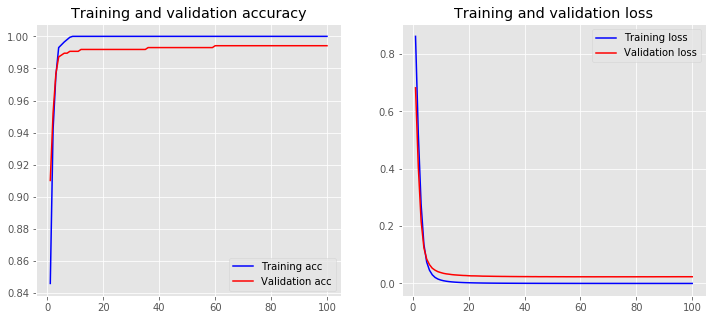

In [20]:
plot_history(history)

# Hyperparameter Tuning

In [22]:
def create_model(learning_rate=0.01, activation='relu'):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation=activation))
    model.add(layers.Dense(3, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer = opt,
                  loss = 'categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [31]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [33]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 10,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [34]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
2284/2284 [==============================] - 1s 513us/step - loss: 1.0757 - accuracy: 0.6484
Epoch 2/10
2284/2284 [==============================] - 1s 290us/step - loss: 1.0441 - accuracy: 0.7097
Epoch 3/10
2284/2284 [==============================] - 1s 280us/step - loss: 1.0073 - accuracy: 0.7474
Epoch 4/10
2284/2284 [==============================] - 1s 276us/step - loss: 0.9669 - accuracy: 0.7877
Epoch 5/10
2284/2284 [==============================] - 1s 270us/step - loss: 0.9282 - accuracy: 0.8402
Epoch 6/10
2284/2284 [==============================] - 1s 274us/step - loss: 0.8915 - accuracy: 0.8783
Epoch 7/10
2284/2284 [==============================] - 1s 268us/step - loss: 0.8568 - accuracy: 0.8914
Epoch 8/10
2284/2284 [==============================] - 1s 271us/step - loss: 0.8235 - accuracy: 0.9019
Epoch 9/10
2284/2284 [==============================] - 1s 278us/step - loss: 0.7918 - accuracy: 0.9063
Epoch 10/10
2284/2284 [=====================

2285/2285 [==============================] - 1s 481us/step - loss: 0.0057 - accuracy: 0.9982
Epoch 3/20
2285/2285 [==============================] - 1s 432us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 4/20
2285/2285 [==============================] - 1s 451us/step - loss: 3.9675e-04 - accuracy: 1.0000
Epoch 5/20
2285/2285 [==============================] - 1s 449us/step - loss: 2.6103e-04 - accuracy: 1.0000
Epoch 6/20
2285/2285 [==============================] - 1s 452us/step - loss: 1.8898e-04 - accuracy: 1.0000
Epoch 7/20
2285/2285 [==============================] - 1s 616us/step - loss: 1.4342e-04 - accuracy: 1.0000
Epoch 8/20
2285/2285 [==============================] - 1s 503us/step - loss: 1.1323e-04 - accuracy: 1.0000
Epoch 9/20
2285/2285 [==============================] - 1s 442us/step - loss: 9.1426e-05 - accuracy: 1.0000
Epoch 10/20
2285/2285 [==============================] - 1s 485us/step - loss: 7.1442e-05 - accuracy: 1.0000
Epoch 11/20
2285/2285 [=======================

2284/2284 [==============================] - 1s 347us/step - loss: 0.3101 - accuracy: 0.9676
Epoch 25/30
2284/2284 [==============================] - 1s 348us/step - loss: 0.2914 - accuracy: 0.9720
Epoch 26/30
2284/2284 [==============================] - 1s 349us/step - loss: 0.2739 - accuracy: 0.9759
Epoch 27/30
2284/2284 [==============================] - 1s 356us/step - loss: 0.2576 - accuracy: 0.9785
Epoch 28/30
2284/2284 [==============================] - 1s 354us/step - loss: 0.2423 - accuracy: 0.9816
Epoch 29/30
2284/2284 [==============================] - 1s 353us/step - loss: 0.2281 - accuracy: 0.9847
Epoch 30/30
2284/2284 [==============================] - 1s 262us/step
Epoch 1/30
2285/2285 [==============================] - 1s 635us/step - loss: 1.0671 - accuracy: 0.7120
Epoch 2/30
2285/2285 [==============================] - 1s 362us/step - loss: 1.0101 - accuracy: 0.8171
Epoch 3/30
2285/2285 [==============================] - 1s 350us/step - loss: 0.9424 - accuracy: 0.8770

2284/2284 [==============================] - 1s 471us/step - loss: 0.0073 - accuracy: 0.9996
Epoch 9/20
2284/2284 [==============================] - 1s 482us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 10/20
2284/2284 [==============================] - 1s 471us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 11/20
2284/2284 [==============================] - 1s 478us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 12/20
2284/2284 [==============================] - 1s 494us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 13/20
2284/2284 [==============================] - 1s 492us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 14/20
2284/2284 [==============================] - 1s 464us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 15/20
2284/2284 [==============================] - 1s 459us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 16/20
2284/2284 [==============================] - 1s 475us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 17/20
2284/2284 [==============================] - 1s 473us/st

2284/2284 [==============================] - 1s 521us/step - loss: 0.1523 - accuracy: 0.9847
Epoch 23/30
2284/2284 [==============================] - 1s 479us/step - loss: 0.1405 - accuracy: 0.9873
Epoch 24/30
2284/2284 [==============================] - 1s 486us/step - loss: 0.1296 - accuracy: 0.9877
Epoch 25/30
2284/2284 [==============================] - 1s 471us/step - loss: 0.1195 - accuracy: 0.9904
Epoch 26/30
2284/2284 [==============================] - 1s 480us/step - loss: 0.1101 - accuracy: 0.9908
Epoch 27/30
2284/2284 [==============================] - 1s 465us/step - loss: 0.1014 - accuracy: 0.9912
Epoch 28/30
2284/2284 [==============================] - 1s 483us/step - loss: 0.0933 - accuracy: 0.9921
Epoch 29/30
2284/2284 [==============================] - 1s 473us/step - loss: 0.0860 - accuracy: 0.9917
Epoch 30/30
2284/2284 [==============================] - 1s 256us/step
Epoch 1/30
2285/2285 [==============================] - 2s 776us/step - loss: 1.0380 - accuracy: 0.74

2284/2284 [==============================] - 1s 360us/step - loss: 3.7579e-04 - accuracy: 1.0000
Epoch 7/20
2284/2284 [==============================] - 1s 350us/step - loss: 2.8589e-04 - accuracy: 1.0000
Epoch 8/20
2284/2284 [==============================] - 1s 347us/step - loss: 2.2726e-04 - accuracy: 1.0000
Epoch 9/20
2284/2284 [==============================] - 1s 358us/step - loss: 1.8388e-04 - accuracy: 1.0000
Epoch 10/20
2284/2284 [==============================] - 1s 357us/step - loss: 1.5289e-04 - accuracy: 1.0000
Epoch 11/20
2284/2284 [==============================] - 1s 361us/step - loss: 1.2912e-04 - accuracy: 1.0000
Epoch 12/20
2284/2284 [==============================] - 1s 370us/step - loss: 1.1044e-04 - accuracy: 1.0000
Epoch 13/20
2284/2284 [==============================] - 1s 341us/step - loss: 9.5631e-05 - accuracy: 1.0000
Epoch 14/20
2284/2284 [==============================] - 1s 358us/step - loss: 8.3698e-05 - accuracy: 1.0000
Epoch 15/20
2284/2284 [===========

2284/2284 [==============================] - 1s 333us/step - loss: 0.7413 - accuracy: 0.9820
Epoch 19/30
2284/2284 [==============================] - 1s 274us/step - loss: 0.7139 - accuracy: 0.9829
Epoch 20/30
2284/2284 [==============================] - 1s 268us/step - loss: 0.6860 - accuracy: 0.9838
Epoch 21/30
2284/2284 [==============================] - 1s 276us/step - loss: 0.6577 - accuracy: 0.9842
Epoch 22/30
2284/2284 [==============================] - 1s 265us/step - loss: 0.6293 - accuracy: 0.9851
Epoch 23/30
2284/2284 [==============================] - 1s 262us/step - loss: 0.6009 - accuracy: 0.9847
Epoch 24/30
2284/2284 [==============================] - 1s 272us/step - loss: 0.5725 - accuracy: 0.9864
Epoch 25/30
2284/2284 [==============================] - 1s 268us/step - loss: 0.5442 - accuracy: 0.9869
Epoch 26/30
2284/2284 [==============================] - 1s 296us/step - loss: 0.5162 - accuracy: 0.9877
Epoch 27/30
2284/2284 [==============================] - 1s 279us/s

2284/2284 [==============================] - 1s 414us/step - loss: 0.0315 - accuracy: 0.9947
Epoch 3/20
2284/2284 [==============================] - 1s 466us/step - loss: 0.0054 - accuracy: 0.9996
Epoch 4/20
2284/2284 [==============================] - 1s 351us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 5/20
2284/2284 [==============================] - 1s 296us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 6/20
2284/2284 [==============================] - 1s 275us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 7/20
2284/2284 [==============================] - 1s 286us/step - loss: 7.7442e-04 - accuracy: 1.00000s - loss: 7.9104e-04 - accuracy
Epoch 8/20
2284/2284 [==============================] - 1s 295us/step - loss: 6.2146e-04 - accuracy: 1.0000
Epoch 9/20
2284/2284 [==============================] - 1s 283us/step - loss: 5.0665e-04 - accuracy: 1.0000
Epoch 10/20
2284/2284 [==============================] - 1s 266us/step - loss: 4.2439e-04 - accuracy: 1.0000
Epoch 11/20
2284/2284 [===

2285/2285 [==============================] - 1s 357us/step - loss: 0.9619 - accuracy: 0.8311
Epoch 4/10
2285/2285 [==============================] - 1s 350us/step - loss: 0.9067 - accuracy: 0.8420
Epoch 5/10
2285/2285 [==============================] - 1s 360us/step - loss: 0.8498 - accuracy: 0.8630
Epoch 6/10
2285/2285 [==============================] - 1s 355us/step - loss: 0.7881 - accuracy: 0.8818
Epoch 7/10
2285/2285 [==============================] - 1s 426us/step - loss: 0.7229 - accuracy: 0.8888
Epoch 8/10
2285/2285 [==============================] - 1s 385us/step - loss: 0.6594 - accuracy: 0.8950
Epoch 9/10
2285/2285 [==============================] - 1s 358us/step - loss: 0.6015 - accuracy: 0.8998
Epoch 10/10
2285/2285 [==============================] - 0s 213us/step
Epoch 1/10
2285/2285 [==============================] - 2s 718us/step - loss: 1.0427 - accuracy: 0.6626
Epoch 2/10
2285/2285 [==============================] - 1s 493us/step - loss: 0.9492 - accuracy: 0.6932
Epoc

In [37]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.014288656604598396 and Best Params:  {'learning_rate': 0.01, 'epochs': 20, 'batch_size': 16, 'activation': 'relu'}


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 10)                69490     
_________________________________________________________________
dense_82 (Dense)             (None, 3)                 33        
Total params: 69,523
Trainable params: 69,523
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Valid Accuracy:  0.9930
Testing Accuracy:  0.9963


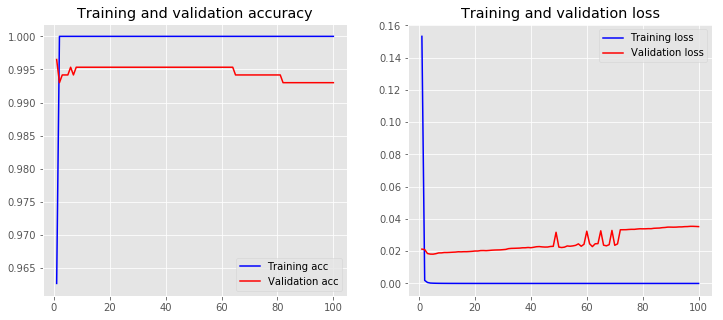

In [104]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

opt = Adam(learning_rate = 0.01)

model.compile(loss='categorical_crossentropy', 
               optimizer=opt, 
               metrics=['accuracy'])
model.summary()

history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=16)

loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

# Model Evaluation: Test Data

In [105]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.996268630027771


Confusion matrix, without normalization


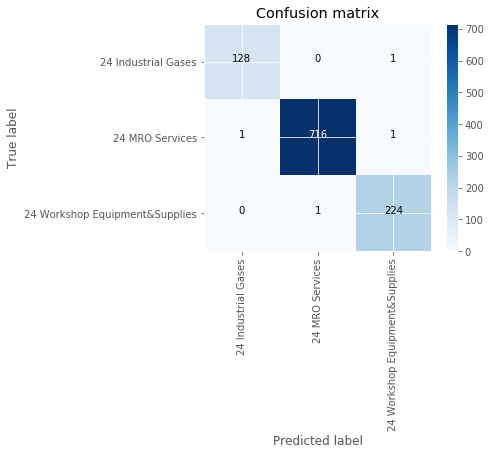

In [106]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [107]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9924358822834181

In [108]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,0.992248,0.992248,0.992248,129
1,24 MRO Services,0.998605,0.997214,0.997909,718
2,24 Workshop Equipment&Supplies,0.991150,0.995556,0.993348,225


In [113]:
text_labels[i]

'24 Industrial Gases'

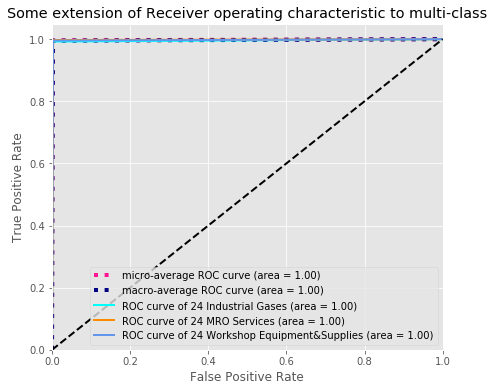

In [120]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [110]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.99')

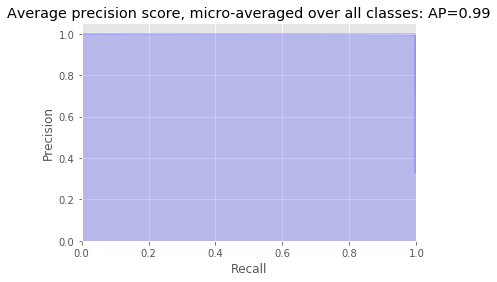

In [111]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

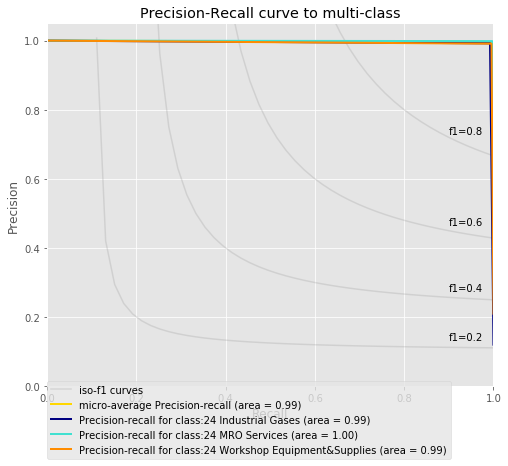

In [122]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()